In [1]:
# Импорт библиотек
import os
import time

import ASW
import GTU
import KU_TU
import mat_properties as prop
import numpy as n
import pandas as pd
import SP
from scipy.optimize import root

# таблица номинального режима
gas_streams0 = pd.read_excel("streams0.xlsx", sheet_name="gas", index_col=0)
water_streams0 = pd.read_excel("streams0.xlsx", sheet_name="water", index_col=0)
GTU_ISO = pd.read_excel("input.xlsx", sheet_name="ISO", index_col=0)
GTU_input = pd.read_excel("input.xlsx", sheet_name="GTU_input", index_col=0)
# рабочая таблица (=номинал в 1 итерации)
gas_streams = pd.read_excel("streams.xlsx", sheet_name="gas", index_col=0)
water_streams = pd.read_excel("streams.xlsx", sheet_name="water", index_col=0)
# рабочая таблица показателей блоков
heaters = pd.read_excel("blocks.xlsx", sheet_name="heaters", index_col=0)
electric = pd.read_excel("blocks.xlsx", sheet_name="electric", index_col=0)
accumulation = pd.read_excel("blocks.xlsx", sheet_name="accumulation", index_col=0)
# Состав газов в номинале
gasmix = "Nitrogen*Oxygen*CO2*Water*Argon"
# Считывание рефпропа
RP = prop.init_REFPROP(r"C:\Program Files (x86)\REFPROP")
fractiongas0 = (
    gas_streams0.at["GTU-PEVD", "N2"],
    gas_streams0.at["GTU-PEVD", "O2"],
    gas_streams0.at["GTU-PEVD", "CO2"],
    gas_streams0.at["GTU-PEVD", "H2O"],
    gas_streams0.at["GTU-PEVD", "Ar"],
)

gas0 = prop.Materials_prop(
    gasmix,
    fractiongas0,
    prop.REFPROP_h_s,
    prop.REFPROP_p_t,
    prop.REFPROP_p_h,
    prop.REFPROP_p_s,
    prop.REFPROP_p_q,
    prop.REFPROP_t_q,
    prop.REFPROP_p_rho,
    prop.REFPROP_s_q,
    RP=RP,
)
water = prop.Materials_prop(
    "water",
    [1.0, 0, 0, 0, 0],
    prop.REFPROP_h_s,
    prop.REFPROP_p_t,
    prop.REFPROP_p_h,
    prop.REFPROP_p_s,
    prop.REFPROP_p_q,
    prop.REFPROP_t_q,
    prop.REFPROP_p_rho,
    prop.REFPROP_s_q,
    RP=RP,
)

# Задание энтальпий газа в номинальном режиме
Temperatures = gas_streams0.loc["GTU-KU":"GPK-out", "T"]
Pressure = gas_streams0.loc["GTU-KU", "P"]
Enthalpies = list(map(lambda x: gas0.p_t(Pressure, x)["h"], Temperatures))
gas_streams0.loc["GTU-KU":"GPK-out", "H"] = Enthalpies


# Состав газов при частичной нагрузке
fractiongas = (
    gas_streams.at["GTU-PEVD", "N2"],
    gas_streams.at["GTU-PEVD", "O2"],
    gas_streams.at["GTU-PEVD", "CO2"],
    gas_streams.at["GTU-PEVD", "H2O"],
    gas_streams.at["GTU-PEVD", "Ar"],
)
gas1 = prop.Materials_prop(
    gasmix,
    fractiongas,
    prop.REFPROP_h_s,
    prop.REFPROP_p_t,
    prop.REFPROP_p_h,
    prop.REFPROP_p_s,
    prop.REFPROP_p_q,
    prop.REFPROP_t_q,
    prop.REFPROP_p_rho,
    prop.REFPROP_s_q,
    RP=RP,
)

# Основные константы
Calcmethod = "hybr"
KPD_PN = 0.8074
KPD_KN = 0.75
KPD_to = 0.99
KPD_SP = 0.99

Calctolerance = 10**-2
Teplo = 1
Maxiterations_KU_TU = 20
Maxiterations_cotel = 4
Maxiterations_turbine = 30
steamVD_fraction_to_turbine = 1
steamVD_to_turbine = 0

# --------------------------------- ВАРЬИРУЕМЫЕ ПАРАМЕТРЫ
# Задаем нагрузку
GTU_input.at["n", 1] = 1
GTU_input.at["tair", 1] = 7
vremya = 4
# # Выбор происходит ли зарядка : 1 - заряжается, 2 - разряжается, любое другое число - не участвует в расчете
ASWbul = 1
# ----------------------------------------------------------
# print(GTU_input)
############################################################
# Теплосеть
gas_streams.loc["AIR", "T":"P"] = [GTU_input.loc["tair", 1], 0.1]
water_streams.loc["AIR", "T":"P"] = [GTU_input.loc["tair", 1], 0.1]
Tnv = gas_streams.at["AIR", "T"]
water_streams.at["SWIN-TURB", "T"] = SP.Tset(Tnv)[1]
water_streams.at["SP2-WOUT", "T"] = SP.Tset(Tnv)[0]

water_streams.at["SWOUT", "T"] = SP.Tset(Tnv)[0]
water_streams.at["SWIN", "T"] = SP.Tset(Tnv)[1]
# print(water_streams)
############################################################
# --------------------------------Расчет ГТУ
Gas_turbine = GTU.gtu(GTU_ISO, "GTU-KU")
Gas_turbine_res = Gas_turbine.calc(GTU_input)
electric.at["GTU", "N"] = Gas_turbine_res["N"]
electric.at["GTU", "KPD"] = Gas_turbine_res["eff"]
electric.at["DK", "N"] = Gas_turbine_res["Ndk"]
gas_streams = pd.read_excel("streams.xlsx", sheet_name="gas", index_col=0)
gas_streams.at["GTU-KU", "T"] = Gas_turbine_res["T"]
gas_streams.at["GTU-KU", "G"] = Gas_turbine_res["G"]
gas_streams.at["GTU-KU", "P"] = 0.1
gas_streams.at["GTU-KU", "H"] = gas0.p_t(
    gas_streams.at["GTU-KU", "P"], gas_streams.at["GTU-KU", "T"]
)["h"]
Gas_turbine_composition = pd.read_excel(
    "input.xlsx", sheet_name="Gas_composition0", index_col=0
)

# Параметры газа на выходе в КУ
gas_streams.loc["GTU-PEVD", "T":"P"] = gas_streams.loc["GTU-KU", "T":"P"]
gas_streams.at["GTU-PEVD", "G"] = gas_streams.loc["GTU-KU", "G"]
gas_streams.loc["GTU-PEVD", "N2":"Ar"] = Gas_turbine_composition.loc[
    "Fraction", "N2":"Ar"
]
# --------------------------------------------------------------------------
# Class KU+TU
KU_and_TU = KU_TU.ku_tu(
    gas0,
    gas1,
    water,
    gas_streams0,
    gas_streams,
    water_streams0,
    water_streams,
    heaters,
    electric,
    "PEVD-DROSVD",
    "PPND-DROSND",
    "DROSVD-TURBVD",
    "DROSND-TURBND",
    Calcmethod,
    KPD_SP,
    KPD_KN,
    KPD_to,
    KPD_PN,
    steamVD_fraction_to_turbine,
    steamVD_to_turbine,
)

ASW = ASW.Accum(
    water,
    water_streams,
    accumulation,
    stream12="ASW-WOUT",
    stream11="SP2-ASW",
    stream_obratnoi_setevoi_vody="SWIN-TURB",
    stream_pryamoi_setevoi_vody="SP2-WOUT",
    T_nar_vozd=water_streams.at["AIR", "T"],
)

ASW.set_construct(
    Diametr=2, kolichestvo=10, Visota=10, lambda_min_vata=0.045, delta_min_vata=0.01
)

start_time = time.time()

# # если Зарядка
if ASWbul == 1:
    G_ASW_zarydka = ASW.zaryadka(vremya)["G"]
    water_streams.at["SWIN-TURB", "G"] = water_streams.at["SWIN", "G"] + G_ASW_zarydka
    water_streams.at["SP2-WOUT", "G"] = water_streams.at["SWIN", "G"] + G_ASW_zarydka
    # если разрядка
if ASWbul == 2:
    ASW.zaryadka(vremya)
    ASW.jdat(12)
    G_ASW_razryadka = ASW.razryadka(vremya)["G"]
    water_streams.at["SWIN-TURB", "G"] = water_streams.at["SWIN", "G"] - G_ASW_razryadka
    water_streams.at["SP2-WOUT", "G"] = water_streams.at["SWIN", "G"] - G_ASW_razryadka
    water_streams.at["SWOUT", "H"] = water.p_t(
        water_streams.at["SWOUT", "P"], water_streams.at["SWOUT", "T"]
    )["h"]
    water_streams.at["SP2-WOUT", "H"] = (
        water_streams.at["SWOUT", "H"] * water_streams.at["SWOUT", "G"]
        - water_streams.at["ASW-WOUT", "H"] * G_ASW_razryadka
    ) / (water_streams.at["SWOUT", "G"] - G_ASW_razryadka)
    water_streams.at["SP2-WOUT", "T"] = water.p_h(
        water_streams.at["SP2-WOUT", "P"], water_streams.at["SP2-WOUT", "H"]
    )["T"]

KU_and_TU.calculate(
    Teplo,
    Calctolerance,
    Maxiterations_KU_TU,
    Maxiterations_cotel,
    Maxiterations_turbine,
)

print(
    "Степень сухости пара в ЭВД: ",
    water.p_h(water_streams.at["EVD-IVD", "P"], water_streams.at["EVD-IVD", "H"])["Q"],
)
print(
    "Степень сухости пара в ГПК: ",
    water.p_h(water_streams.at["GPK-IND", "P"], water_streams.at["GPK-IND", "H"])["Q"],
)

print(f"fin КУ и ТУ:--- {round((time.time() - start_time), 1)} сек. ---")
electric

Относительная мощность ГТУ в ГТУ 1
67573479.75379118
Достигнуто максимальное количество итераций контура высокого давления
Достигнуто максимальное количество итераций контура низкого давления
Достигнуто максимальное количество итераций контура низкого давления
Повышена точность расчета котла для увеличения сходимости
dQ/Q ПЕВД+ИВД+ЭВД 2.5654862081790806
dQ/Q ПЕВД+ИВД+ЭВД -1.4687667224243253
dQ/Q ПЕВД+ИВД+ЭВД 0.7137432439490226
dQ/Q ПЕВД+ИВД+ЭВД -0.3524432016022294
dQ/Q ПЕВД+ИВД+ЭВД 0.17353758238507988
Достигнуто максимальное количество итераций контура высокого давления
dQ/Q ППНД+ИНД+ГПК 0.41906068456177115
dQ/Q ППНД+ИНД+ГПК -0.0687730139731089
Fin котел-утилизатора:--- 24.91 сек. ---
dQ/Qsumm 0.074137248817404
Fin турбоустановка:--- 0.11 сек. ---
Fin котел-утилизатора:--- 6.59 сек. ---
dQ/Qsumm 0.0031181552231150955
Fin турбоустановка:--- 0.06 сек. ---
Fin котел-утилизатора:--- 2.4 сек. ---
dQ/Qsumm 0.0014718780984329766
Fin турбоустановка:--- 0.06 сек. ---
Fin котел-утилизатора:--- 1

,Ni,N,KPDm,KPD
PEN,0.696186,0.713265,0.976055,0.807400
CVD,NaN,NaN,NaN,NaN
CND,NaN,NaN,NaN,NaN
GTU,NaN,157.979400,NaN,33.745787
DK,NaN,6.285084,NaN,NaN
Turbine,57.638166,NaN,NaN,NaN
Tots1,37.396770,NaN,NaN,0.848254
Tots2,15.016818,NaN,NaN,0.680249
Tots3,5.121130,NaN,NaN,0.642093
Tots4,0.103448,NaN,NaN,0.104168


In [9]:
result = {
    "GTU": round(electric.at["GTU", "N"], 4),
    "GTU_KPD": round(electric.at["GTU", "KPD"], 4),
    "Turbine": round(electric.at["Turbine", "Ni"], 4),
    "KN": round(electric.at["KN", "Ni"], 4),
    "DK": round(electric.at["DK", "N"], 4),
    "PEN": round(electric.at["PEN", "Ni"], 4),
    "Turbine_Qt":round(heaters.at["SP2", "Qw"]+heaters.at["SP1", "Qw"]+heaters.at["OD", "Qw"], 4),
    "ASW_Qt":round(accumulation.at["ASW", "Qw"]/(vremya*3600), 4)
    }
result

{'GTU': 157.9794,
 'GTU_KPD': 33.7458,
 'Turbine': 57.6382,
 'KN': 0.0551,
 'DK': 6.2851,
 'PEN': 0.6962,
 'Turbine_Qt': 171.7659,
 'ASW_Qt': 4.6926}

In [3]:
electric

,Ni,N,KPDm,KPD
PEN,0.696186,0.713265,0.976055,0.807400
CVD,NaN,NaN,NaN,NaN
CND,NaN,NaN,NaN,NaN
GTU,NaN,157.979400,NaN,33.745787
DK,NaN,6.285084,NaN,NaN
Turbine,57.638166,NaN,NaN,NaN
Tots1,37.396770,NaN,NaN,0.848254
Tots2,15.016818,NaN,NaN,0.680249
Tots3,5.121130,NaN,NaN,0.642093
Tots4,0.103448,NaN,NaN,0.104168


In [4]:
heaters

,Qw,Qg,KPD
PEVD,42245.954600,42672.681414,0.99
IVD,89163.231167,90063.869865,0.99
EVD,40744.214652,41155.772376,0.99
PPND,1577.960612,1593.899608,0.99
IND,32349.895421,32676.662042,0.99
GPK,38739.080753,39130.384599,0.99
SP2,85.942563,NaN,0.99
SP1,78.846342,NaN,0.99
OD,6.976946,NaN,0.99
NaN,NaN,NaN,NaN


In [5]:
accumulation

,Qw,T
ASW,67573.479754,90.0


In [6]:
Errors_water = abs(water_streams - water_streams0) / water_streams0 * 100
Errors_gas = abs(gas_streams - gas_streams0) / gas_streams0 * 100
Errors_gas
Errors_water

,G,H,P,S,T,X
AIR,NaN,NaN,NaN,NaN,53.333333,NaN
ASW-OD,NaN,NaN,NaN,NaN,NaN,NaN
ASW-WOUT,NaN,NaN,NaN,NaN,NaN,NaN
BND-PEN,0.162131,1.688564,6.522658,NaN,1.638159,NaN
DOOTB1,49.717790,5.354835,81.994121,5.097133,NaN,NaN
DOOTB2,0.163671,3.103461,59.949074,2.718701,23.814319,NaN
DROSND-TURBND,1.563117,0.226003,8.794229,0.396063,2.010716,NaN
DROSVD-ST,NaN,NaN,NaN,NaN,NaN,NaN
DROSVD-TURBVD,0.162131,0.215499,0.449318,NaN,0.622727,NaN
ENDOFVD,0.162131,0.701318,10.143197,NaN,5.414782,NaN


In [7]:
GTU_input

,1,2,3,4,5,6
tair,7,NaN,NaN,NaN,NaN,NaN
n,1,NaN,NaN,NaN,NaN,NaN
Pin,0,NaN,NaN,NaN,NaN,NaN
Pout,0,NaN,NaN,NaN,NaN,NaN


,T,P,H,G,S,X
AIR,7.000000,0.100000,NaN,NaN,NaN,NaN
PEVD-DROSVD,508.075368,8.369330,3415.149959,63.297209,6.727231,NaN
IVD-PEVD,300.993570,8.708763,2747.704912,63.297209,NaN,NaN
EVD-IVD,298.985445,8.708763,1339.049699,63.297209,NaN,NaN
PEN-EVD,163.501699,8.708763,695.340234,63.297209,NaN,NaN
BND-PEN,162.039686,0.650976,684.341546,63.297209,NaN,NaN
PPND-DROSND,207.590451,0.645043,2864.937424,14.990716,6.966034,NaN
IND-PPND,162.039686,0.650976,2759.663570,14.990716,NaN,NaN
GPK-IND,158.386264,0.650976,668.500609,78.287925,NaN,NaN
GPK-REC,158.386264,0.650976,668.500609,92.946211,NaN,NaN


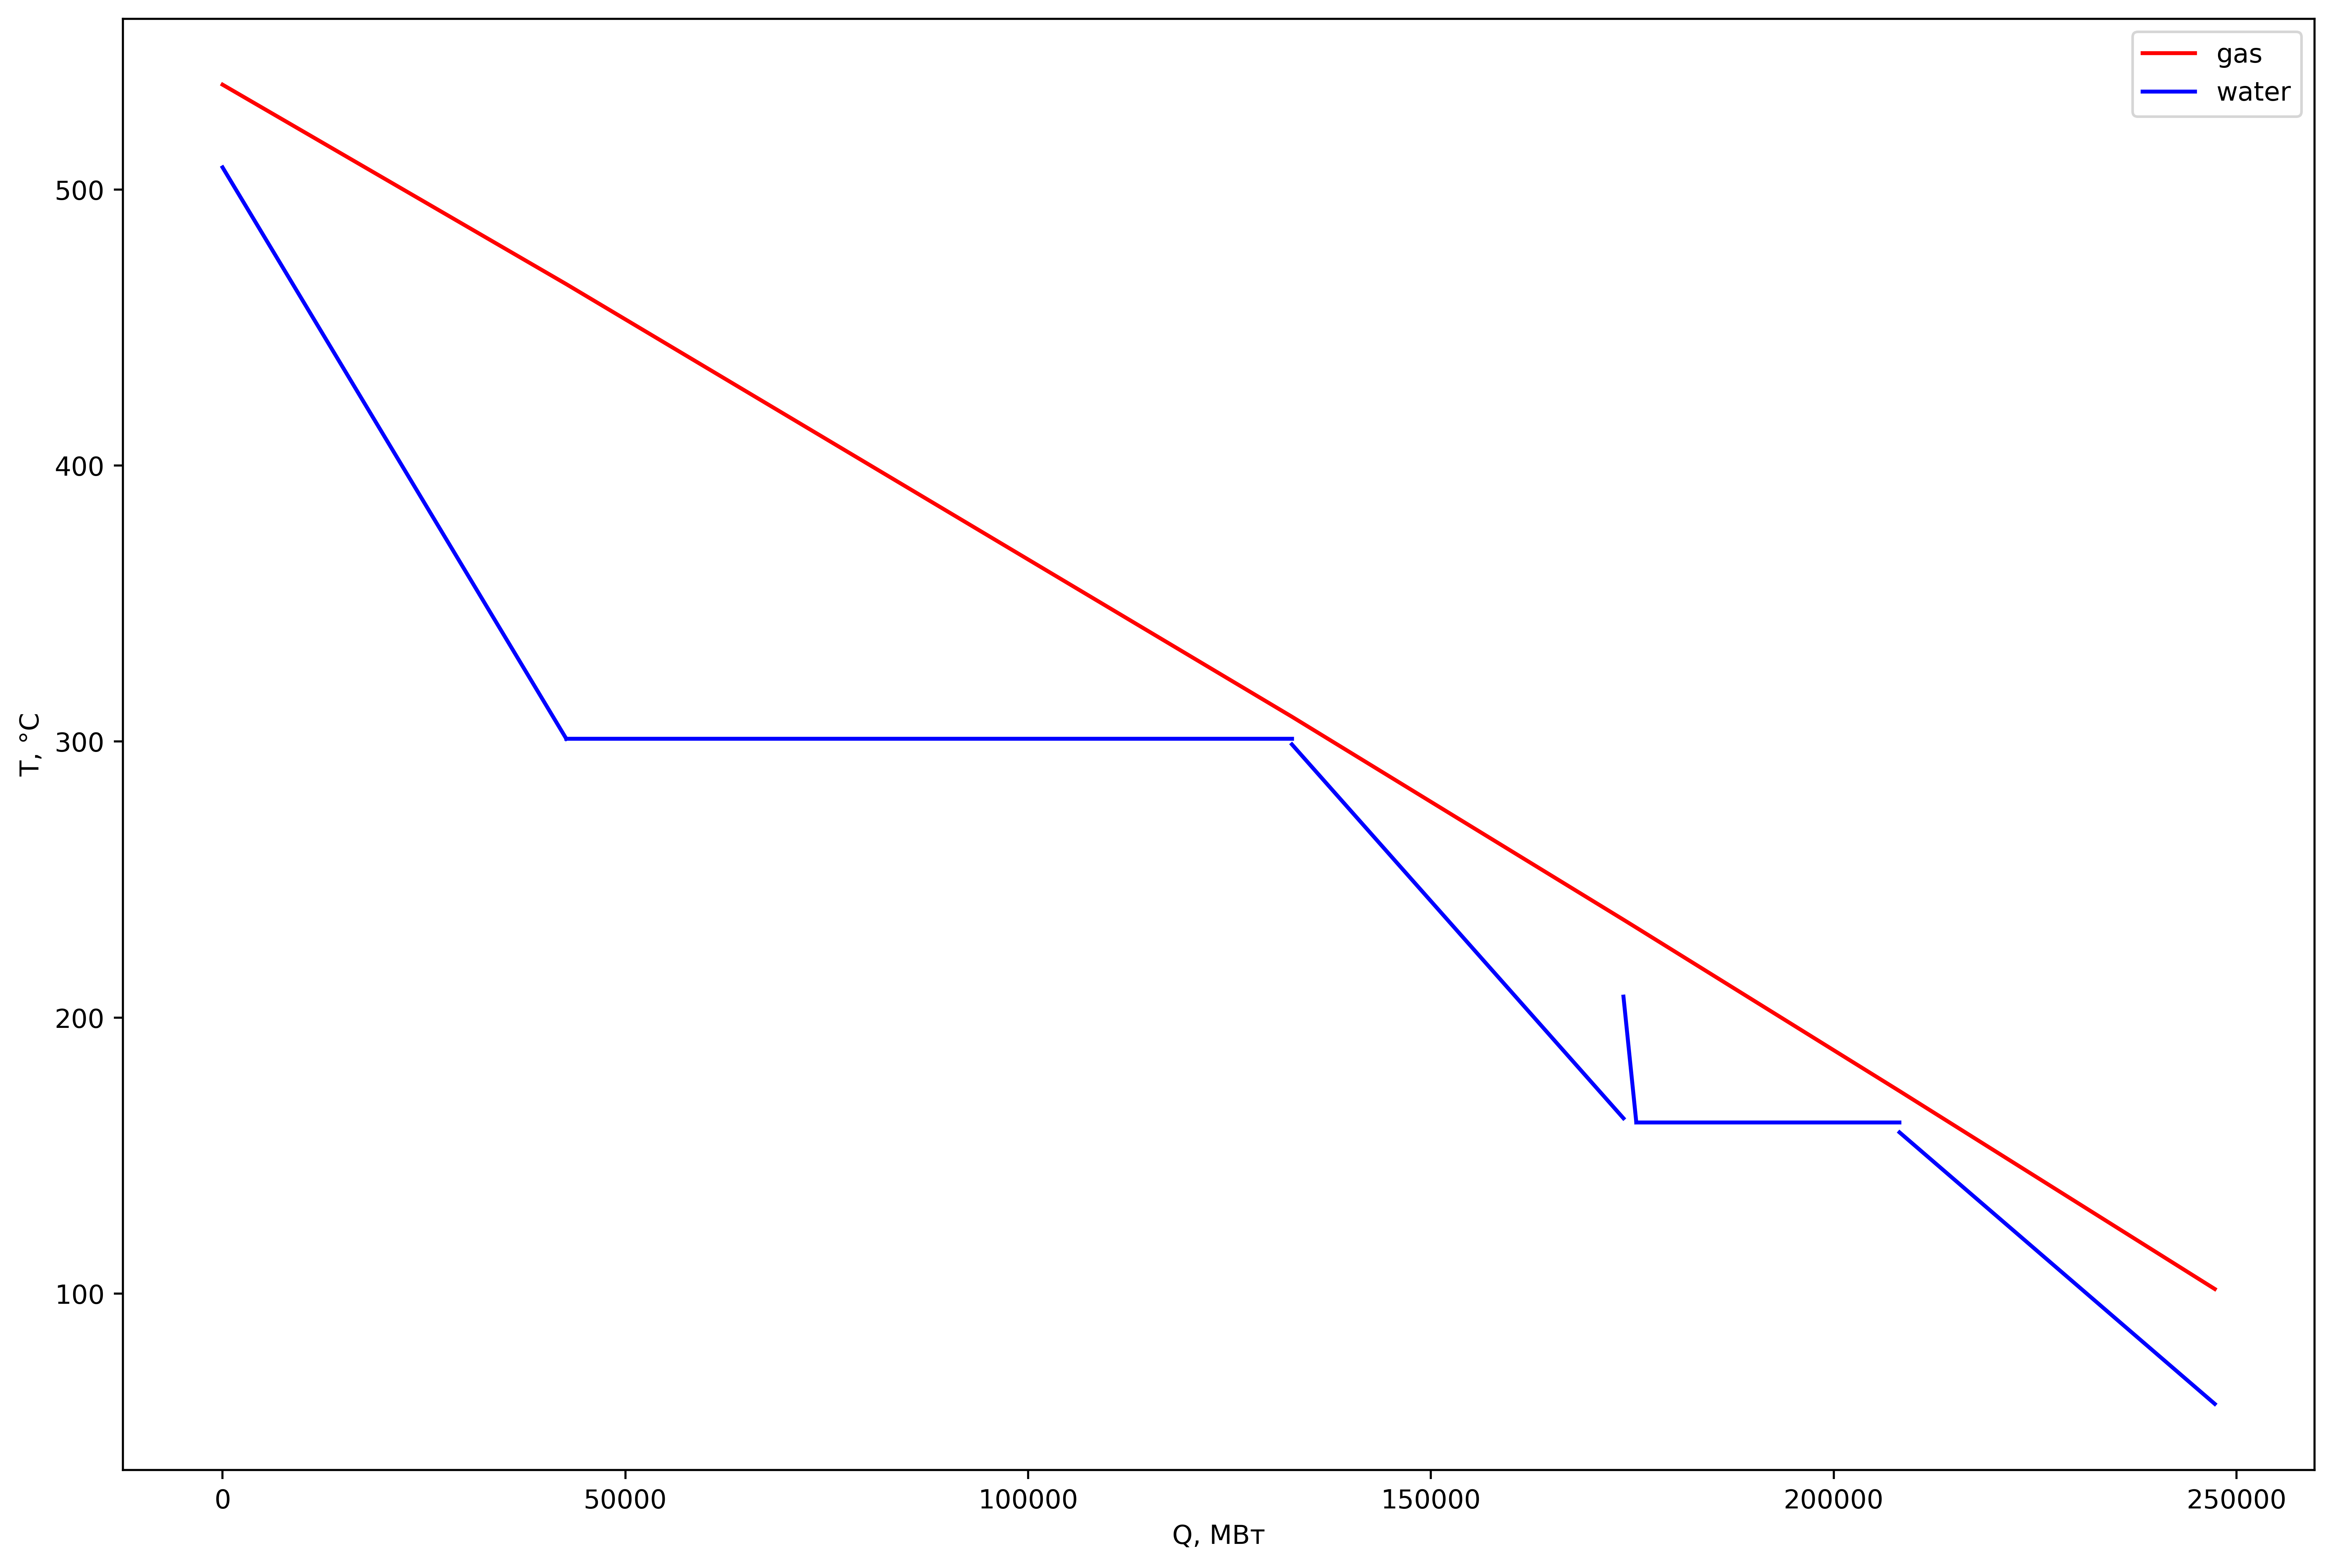

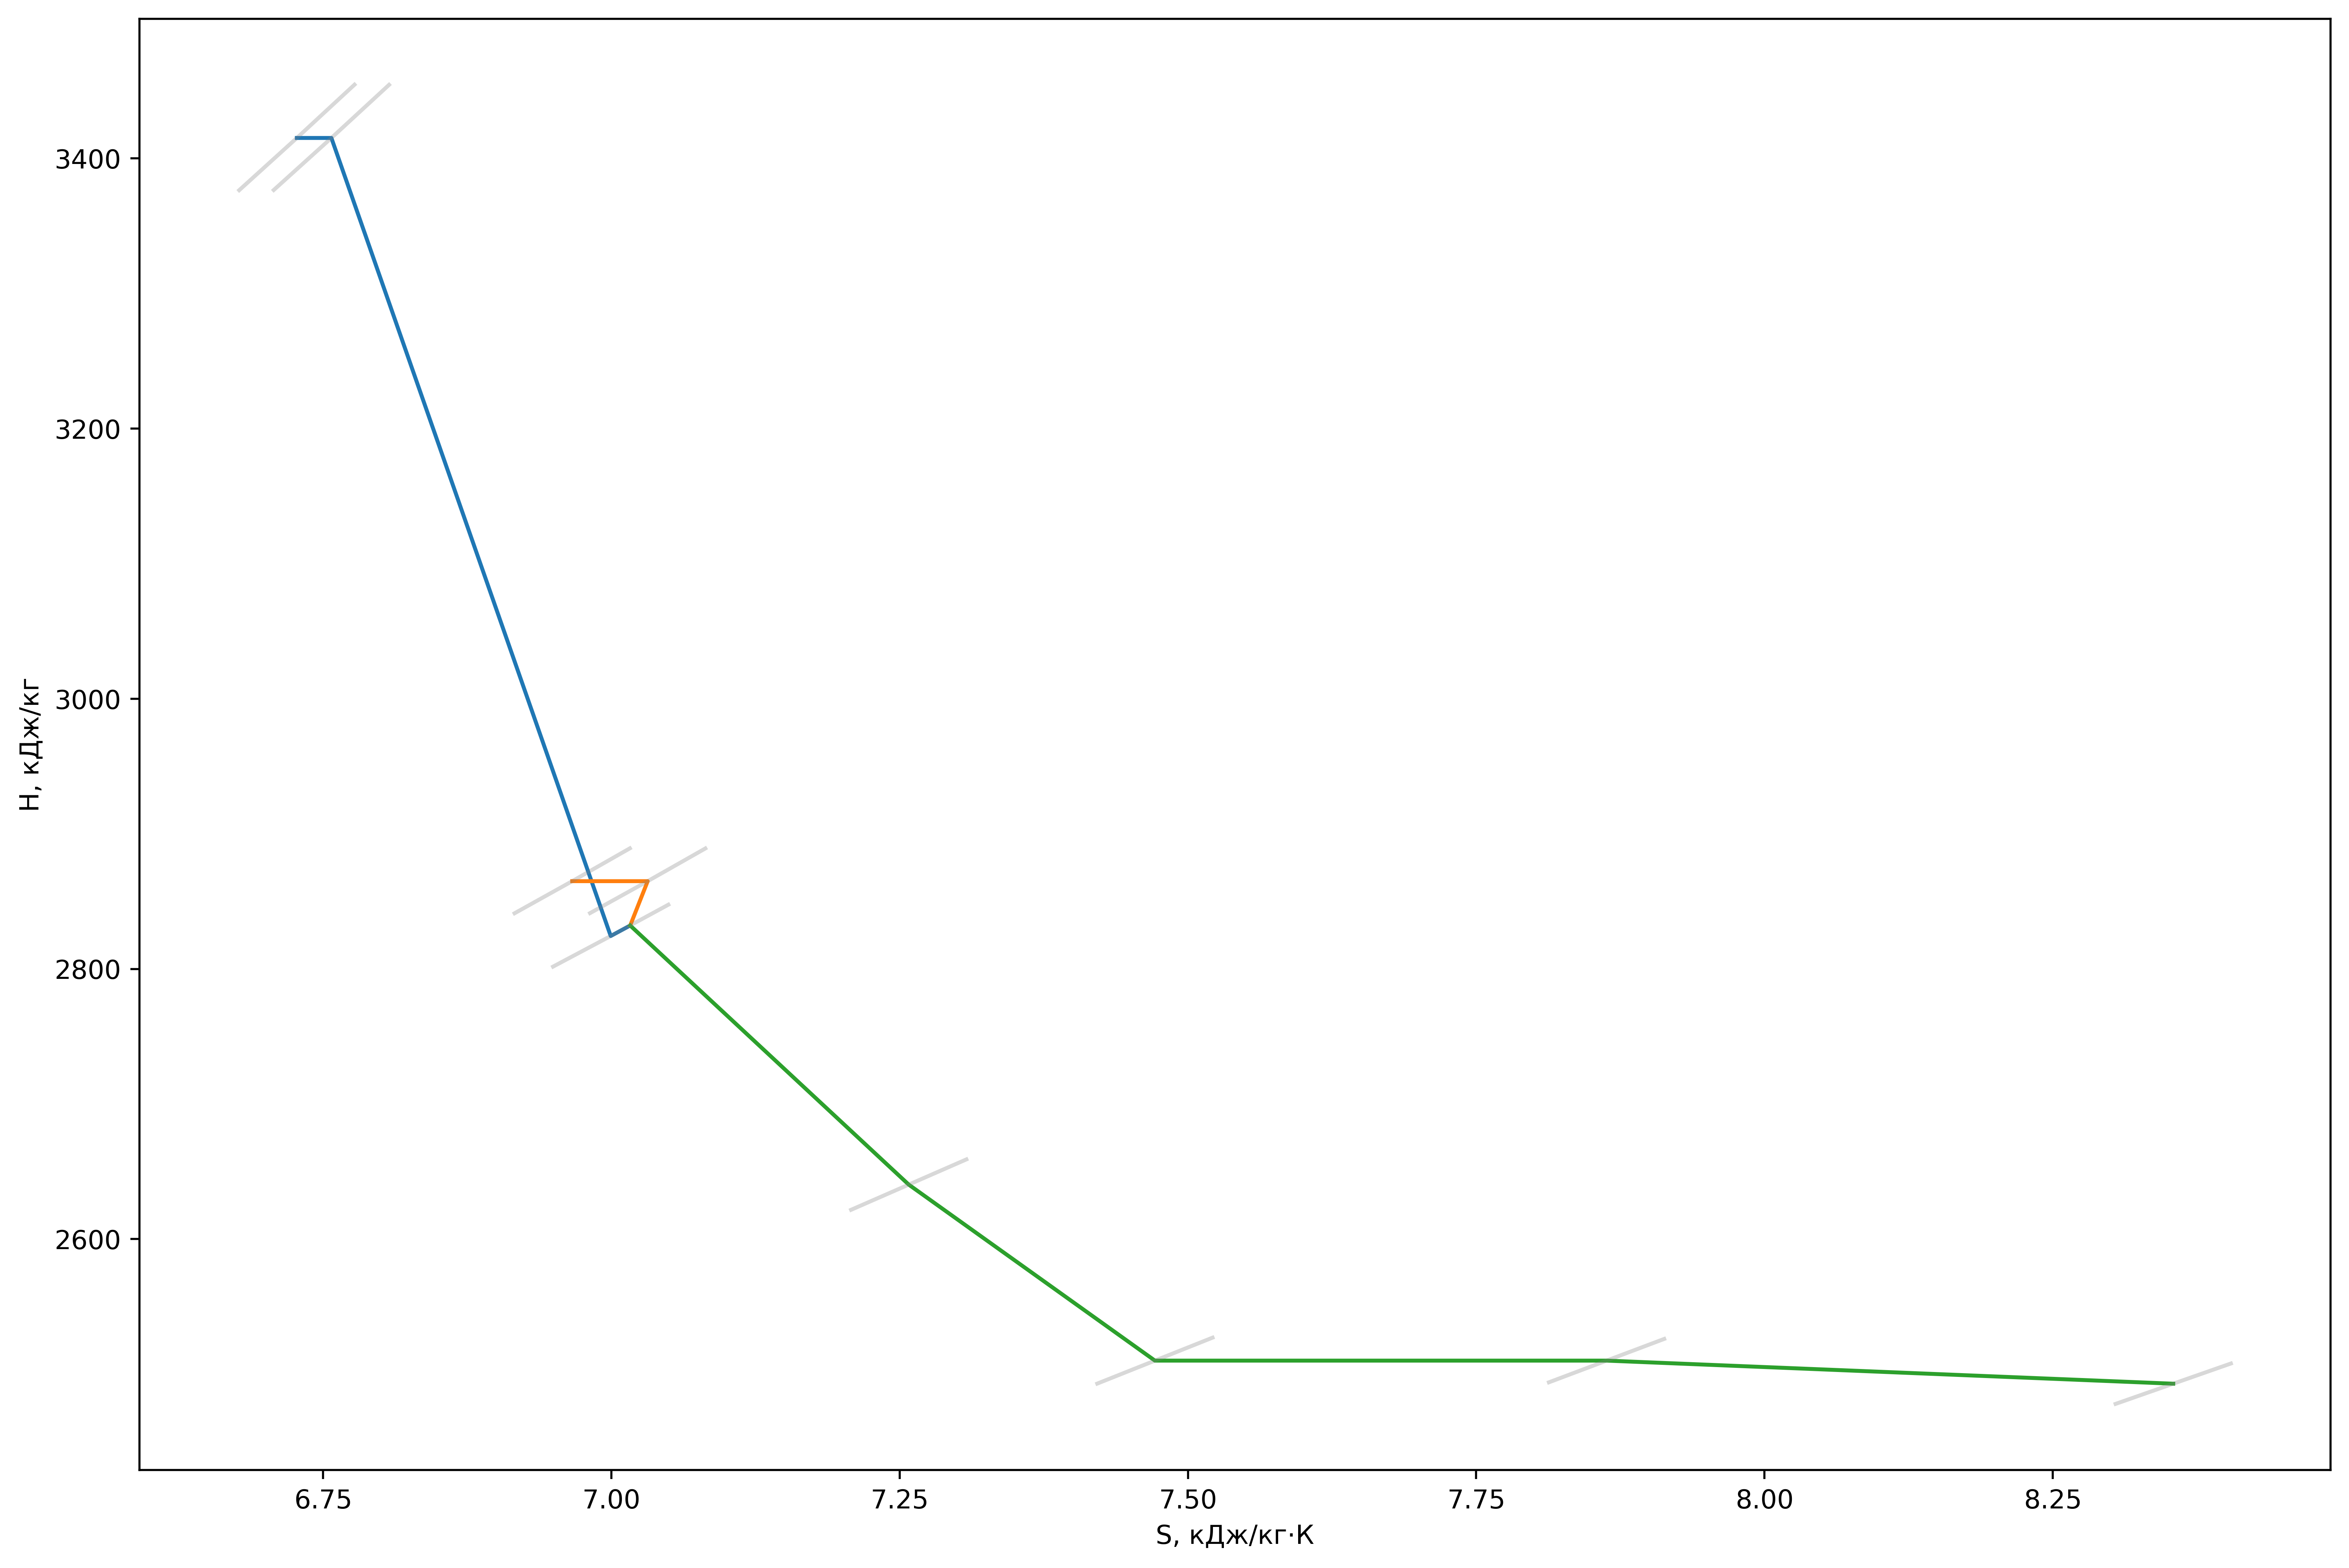

In [8]:
import Grafiki

Grafiki.Q_t_diagram(gas_streams, water_streams, heaters, 15, 10)
Grafiki.H_S_diagram(water, water_streams, 15, 10)
water_streams